# pytorch手把手實作: PyTorch Model Loading <br>

<font size=4>
這篇文章主要說明Pytorch model在讀入電腦內可能會遇到什麼問題<br><br>
前面的內容已經教大家怎麼訓練模型和保存模型<br><br>
那之後關掉執行程式或是換一台電腦，但我們要用前面訓練好的模型inferecne(或是fine-tuning)的時候會遇到什麼問題<br>
    
1. CheckPoint能不能直接讀取? <br><br>

2. CheckPoint是讀在CPU? GPU?<br>
    
本範例採用模型為15_pytorch_objectdetection_yolov1.ipynb訓練出來的模型<br><br>
如果沒看過也可以去[YOLOv1_RestNet18.pth](https://drive.google.com/file/d/1vuQrQukLD3P8aKTqeFVs8fWaqfbZCRwW/view?usp=sharing)來下載這篇的範例權重。<br>
    

## 1. CheckPoint 直接load?

In [1]:
import torch
model = torch.load( 'YOLOv1_RestNet18.pth')

AttributeError: Can't get attribute 'model_yolo' on <module '__main__'>

<font size=4> 大家可以看一下錯誤訊息 </font><br><br>
<font size=4 color='red'> AttributeError: Can't get attribute 'model_yolo' on <module '__main__'> </font><br>

<font size=4> 最直接的問題就是沒有 model_yolo，這個是什麼????? </font>  <br> 
    
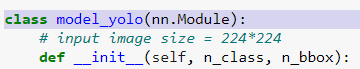 
    
<font size=4> 也就是我們保存YOLOv1_RestNet18.pth的時候用到的「模型宣告」 </font>  <br> 
<font size=4> 所以我們在讀取模型前需要宣告pytorch模型 </font>   
    

In [2]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import torch
class model_yolo(nn.Module):
    # input image size = 224*224
    def __init__(self, n_class, n_bbox):
        super(model_yolo, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(512, 512)
        self.bn = nn.BatchNorm1d(512)
        self.relu = nn.ReLU(inplace=True)
        
        self.bb = nn.Linear(512, 7 * 7 * ( n_bbox * 5 + n_class))

    def forward(self, x):
        # b * 3 * 224 * 224
        nbatch = x.shape[0]
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)    
        x = self.bb(x)        
        x = x.view(nbatch,7,7,-1)
        return x
model = torch.load('YOLOv1_RestNet18.pth')
print('model load successful')

model load successful


<font size=4> 
如果模型load成功，會print出我打的"'model load successful"訊息 <br><br>
1. Pass就恭喜可以直接進行model inference 或是 模型fine-tuning，後續的東西你也可以不用看了。<br><br>

2.但一定有人會出現錯誤 Message:<br><br>
    
>RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location='cpu' to map your storages to the CPU.


這個就是說你拿到的checkpoint(.pth)是用GPU訓練的，你目前在用的電腦沒有GPU只有CPU，所以報錯誤訊息<br><br>
Note: 基本上網路載的到開源模型權重都是用GPU訓練的。

</font>   

## 2. CheckPoint是讀在CPU? GPU? <br>

<font size=4>
所以我們需要去指定模型讀取的位置

In [3]:
device = torch.device("cpu")
model = torch.load( 'YOLOv1_RestNet18.pth', map_location=device)

<font size=4> 理論上，上述過了就OK了，可以進行後續處理<br>
如果有遇到出錯的，後面內容我再繼續解說<br>

## 我們開始進行model inference

In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\user\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle

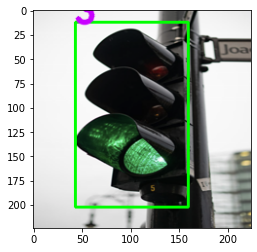

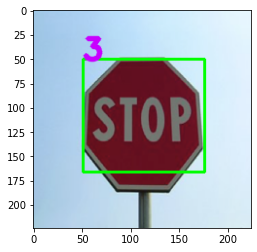

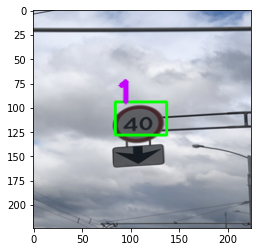

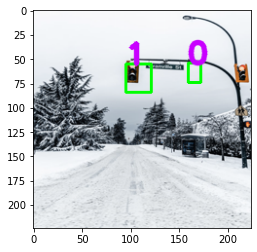

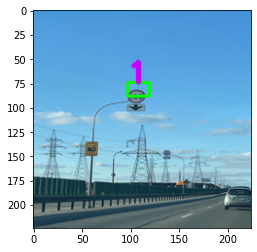

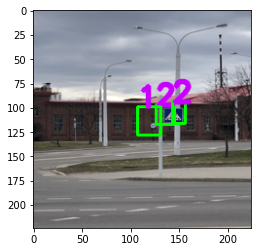

In [4]:
import PIL.Image as Image
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

def model_infernce(model):
    n_class = 4
    n_bbox = 2
    mytransforms = transforms.Compose(
                [   transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                ]) 
    def plot_image_withbbox(img, bboxs, labels=[], flag_bgr=1):
        imageplot=img.copy()
        if len(labels)==0:
            for bb in bboxs:
                cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
        else:
            for bb, label in zip(bboxs,labels):
                cv2.rectangle(imageplot,(int(bb[0]),int(bb[1])),(int(bb[2]),int(bb[3])),(0,255,0),2)
                cv2.putText(imageplot, str(label), (int(bb[0]),int(bb[1])), 0, 1, (200, 0, 255), 4, cv2.LINE_AA)
        if flag_bgr==1:
            plt.imshow(cv2.cvtColor(imageplot, cv2.COLOR_BGR2RGB))
        else:
             plt.imshow(imageplot)
        plt.show()

    def nms(bboxes, scores, threshold=0.5):
        # bboxes: boundary boxes, size: n_box*4 (x_min, y_min, x_max, y_max), pytorch tensor
        # score: confidence for each box, size: n_box, pytorch tensor
        x1 = bboxes[:,0]
        y1 = bboxes[:,1]
        x2 = bboxes[:,2]
        y2 = bboxes[:,3]
        areas = (x2-x1)*(y2-y1)   # [n_box,] area for each box
        _, order = scores.sort(0, descending=True)    # sort
        keep = []
        while order.numel() > 0:       # torch.numel() order裡面的物件數
            if order.numel() == 1:     #保留框只剩下一個
                i = order.item()
                keep.append(i)
                break
            else:
                i = order[0].item()    # 保留scores最大的那個物件框box[i]
                keep.append(i)
            # 计算scores最大的那個物件框box[i] 與其他物件框的IOU (boardcast運算)
            xx1 = x1[order[1:]].clamp(min=x1[i])  
            yy1 = y1[order[1:]].clamp(min=y1[i])
            xx2 = x2[order[1:]].clamp(max=x2[i])
            yy2 = y2[order[1:]].clamp(max=y2[i])
            inter = (xx2-xx1).clamp(min=0) * (yy2-yy1).clamp(min=0)   

            iou = inter / (areas[i]+areas[order[1:]]-inter)  
            idx = (iou <= threshold).nonzero().squeeze()
            if idx.numel() == 0:
                break
            order = order[idx+1]  
        return torch.LongTensor(keep)   
    def pred_box2EachInf(pred_bboxs):
        pred_bbox = pred_bboxs[:,:,0:(n_bbox*5)] # 7 * 7 *40
        pred_class = pred_bboxs[:,:,(n_bbox*5):]    #  7 * 7 * n_class
        pred_bbox = pred_bbox.view(7, 7, n_bbox, 5) # 7* 7* 8*5
        pred_conf = pred_bbox[:,:,:,4]    # torch.Size([ 7, 7, 8])  
        pred_bbox = pred_bbox[:,:,:,0:4]  # torch.Size([ 7, 7, 8, 4])
        pred_class = nn.Softmax(dim=2)(pred_class)    # torch.Size([ 7, 7, 4])
        pred_conf = nn.Sigmoid()(pred_conf)
        pred_bbox = nn.Sigmoid()(pred_bbox)
        return pred_bbox, pred_conf, pred_class

    def xyhw2box(canad_bbox):
        wh = canad_bbox[:,2:4] 
        xy = canad_bbox[:,0:2] 
        xy_min = xy-wh/2
        xy_max = xy+wh/2
        canad_bbox[:,0:2] = xy_min
        canad_bbox[:,2:4] = xy_max
        canad_bbox[canad_bbox<0]=0
        canad_bbox = np.array(canad_bbox, np.uint64)                       
        return canad_bbox


    image_paths =['./dataset/stopsign/images/road32.png',
                  './dataset/stopsign/images/road69.png',
                  './dataset/stopsign/images/road201.png',
                 './dataset/stopsign/images/road12.png',
                 './dataset/stopsign/images/road409.png',
                 './dataset/stopsign/images/road187.png']


    model.eval()
    for image_path in image_paths:
        image = Image.open(image_path, mode='r')
        image = image.convert('RGB')

        image = image.resize((224,224))  # uint8 with RGB mode
        img = mytransforms(image)
        img = torch.unsqueeze(img,dim=0)
        img = img.to(device)

        with torch.no_grad():
            preds_bb = model(img)

        pred_bboxs = preds_bb[0,:,:,:]
        pred_bbox, pred_conf, pred_class = pred_box2EachInf(pred_bboxs)
        pred_bbox = pred_bbox.detach().cpu().numpy()
        pred_conf = pred_conf.detach().cpu().numpy()
        pred_class = pred_class.detach().cpu().numpy()

        pos=np.where(pred_conf>0.25)
        pred_conf = pred_conf[pos[0],pos[1],pos[2]]
        canad_bbox=pred_bbox[pos[0],pos[1],pos[2],:]*224
        canad_bbox = xyhw2box(canad_bbox)
        pred_class=pred_class[pos[0],pos[1]]          
        pred_label=np.argmax(pred_class,axis=1)

        pos_nms = nms(torch.FloatTensor(canad_bbox*1.0), torch.tensor(pred_conf), threshold=0.2)
        canad_bbox = canad_bbox[pos_nms.numpy(),:]
        pred_label = pred_label[pos_nms.numpy()]
        image = np.array(image)
        plot_image_withbbox(image, canad_bbox, pred_label, flag_bgr=0)


    #     labelmap = {'trafficlight': 0, 'speedlimit': 1, 'crosswalk': 2, 'stop': 3}
model_infernce(model)

<font size=4> 理論上，Model Inference結果出來了就OK了

<font size=4 color='red'>**但是....就是有這個 "但是"** </font>
    
    
<font size=4> 一般公開的模型都只保存模型的權重，而不是**整個模型包含權重**都保存 <br>   

我這邊把只保存「模型權重」出來: YOLOv1_RestNet18_state.pth <br>
</font> <br>   

In [5]:
device = torch.device("cpu")
model = torch.load( 'YOLOv1_RestNet18.pth', map_location=device)
torch.save(model.state_dict(), 'YOLOv1_RestNet18_state.pth')

<font size=4> 
    我這邊把只保存「模型權重 (YOLOv1_RestNet18_state.pth)」讀入電腦直接跑Inference看看<br>
</font> <br>  

In [6]:
model = torch.load( 'YOLOv1_RestNet18_state.pth', map_location=device)
model_infernce(model)

AttributeError: 'collections.OrderedDict' object has no attribute 'eval'

<font size=4> 結果是出錯了，原因是這個(YOLOv1_RestNet18_state.pth)只保存了權重。<br>  
在pytorch的權重是存成字典的型態(model.state_dict()，這個dict是python字典)<br>  
所以我們需要宣告模型出來把權重塞回去模型。<br> 

在pytorch的指令就是直接拿模型的  
    
```
model.load_state_dict(checkpoint state_dict)
```
    
函數帶入即可。<br>  
    
Note: 宣告的時候要原本模型的內容物一樣，不然會出錯
</font> 




In [ ]:
model = model_yolo(n_class=4, n_bbox=2)
past_checkpoint = torch.load( 'YOLOv1_RestNet18_state.pth', map_location=device)
model.load_state_dict(past_checkpoint) 
model_infernce(model)

<font size=4> 
後面還有一些範例，將怎麼指定將權重讀到不同的硬體設備 <br>
假設電腦有CPU和多張GPU卡片 <br>
要怎麼把權重指定讀到特定的設備?
</font>


### 1. CPU → CPU或者GPU → GPU:
<font size=4>假設只有一張GPU卡片 或是 沒有GPU卡片

In [7]:
use_cuda = 0
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load( 'YOLOv1_RestNet18.pth', map_location=device)

use_cuda = 1
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load( 'YOLOv1_RestNet18.pth', map_location=device)



### 2.  CPU 1 → GPU 1
<font size=4>假設只有多張GPU卡片，GPU卡0 和 GPU卡1 ... <br>
但我筆電只有一張GPU卡，所以只能測試 "GPU卡0"
    

In [8]:
torch.load('YOLOv1_RestNet18.pth', map_location=lambda storage, loc: storage.cuda(0))

model_yolo(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### 3. GPU 1 → GPU 0
<font size=4> 但我沒有GPU1，所以不管怎麼改他都是讀到GPU0去

In [9]:
torch.load('YOLOv1_RestNet18.pth', map_location={'cuda:1':'cuda:0'})

model_yolo(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### 4. GPU → CPU <br>

<font size=4>
疑.......前面不是說用
</font>


```
use_cuda = 0
device = torch.device("cuda:0" if use_cuda else "cpu")
checkpoint = torch.load( 'YOLOv1_RestNet18.pth', map_location=device)
```

<font size=4>
這個範例的寫法是我就不用管電腦有沒有GPU，他會自己讀進來。
</font>

In [10]:
torch.load('YOLOv1_RestNet18.pth', map_location=lambda storage, loc: storage)

model_yolo(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T